Let's start with downloading the DATA and doing some EDA.

In [38]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("suchintikasarkar/sentiment-analysis-for-mental-health")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/suchintikasarkar/sentiment-analysis-for-mental-health/versions/1


In [39]:
import pandas as pd

# Path to the dataset file
data_path = "/root/.cache/kagglehub/datasets/suchintikasarkar/sentiment-analysis-for-mental-health/versions/1/Combined Data.csv"

# Load the dataset
df = pd.read_csv(data_path)

# Display the first few rows
print(df.head())

   Unnamed: 0                                          statement   status
0           0                                         oh my gosh  Anxiety
1           1  trouble sleeping, confused mind, restless hear...  Anxiety
2           2  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3           3  I've shifted my focus to something else but I'...  Anxiety
4           4  I'm restless and restless, it's been a month n...  Anxiety


In [40]:
#Specify column names
print(df.columns)
#Drop ID column, since it's superflous, just use panda's indexing
df_new = df.drop('Unnamed: 0', axis=1)


Index(['Unnamed: 0', 'statement', 'status'], dtype='object')


In [41]:
#Sanity check
print(df_new.head())
#"Unnamed" column is gone, as intended

                                           statement   status
0                                         oh my gosh  Anxiety
1  trouble sleeping, confused mind, restless hear...  Anxiety
2  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3  I've shifted my focus to something else but I'...  Anxiety
4  I'm restless and restless, it's been a month n...  Anxiety


In [42]:
# Calculate frequency of each label in the 'label' column
label_counts = df_new['status'].value_counts()
print(label_counts)

status
Normal                  16351
Depression              15404
Suicidal                10653
Anxiety                  3888
Bipolar                  2877
Stress                   2669
Personality disorder     1201
Name: count, dtype: int64


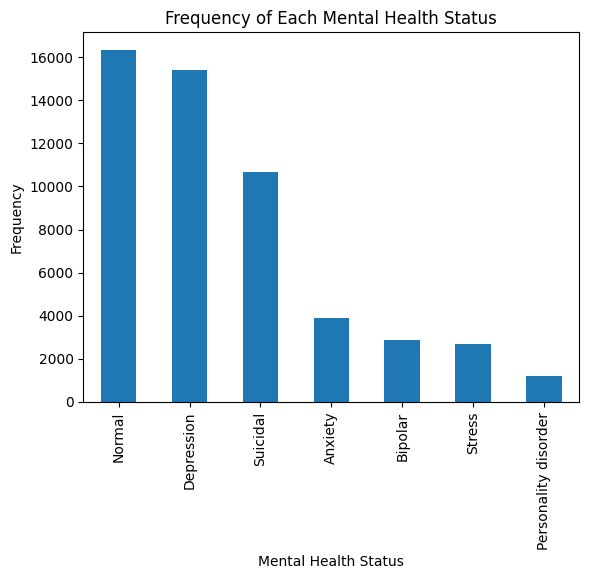

In [43]:
#Bar chart to visualize the distribution of labels
import matplotlib.pyplot as plt

df['status'].value_counts().plot(kind='bar')
plt.xlabel('Mental Health Status')
plt.ylabel('Frequency')
plt.title('Frequency of Each Mental Health Status')
plt.show()

Note that we have very imbalanced data, with certain classifications much less numerous than others. The "normal" classification, expectedly, is the most common one.

In [44]:
#Change all text to lowercase to standardize words
def clean_text_lowercase_only(text):
    if isinstance(text, str):
        # Convert to lowercase
        text = text.lower()
        return text
    return ""

# Apply this to your DataFrame column
df_new['cleaned_statement'] = df_new['statement'].apply(clean_text_lowercase_only)

# Display the cleaned text
print(df_new[['cleaned_statement']].head())


                                   cleaned_statement
0                                         oh my gosh
1  trouble sleeping, confused mind, restless hear...
2  all wrong, back off dear, forward doubt. stay ...
3  i've shifted my focus to something else but i'...
4  i'm restless and restless, it's been a month n...


In [45]:
#Sanity check to make sure capital letters were removed

contains_capital_letters = df_new['cleaned_statement'].str.contains(r"[A-Z]").any()
print("Contains capital letters:", contains_capital_letters)

Contains capital letters: False


In [46]:
# Check for NaNs and empty strings
empty_entries = df_new[df_new['cleaned_statement'].isna() | (df_new['cleaned_statement'] == "")]
print("Number of empty or NaN entries:", len(empty_entries))



Number of empty or NaN entries: 362


In [47]:
# Remove rows where 'cleaned_statement' is either NaN or an empty string
df_new = df_new[df_new['cleaned_statement'].notna() & (df_new['cleaned_statement'] != "")]

In [48]:
#Sanity check--make sure NaN and empty values are removed

print("Any NaN values:", df_new['cleaned_statement'].isna().any())
print("Any empty strings:", (df_new['cleaned_statement'] == "").any())

Any NaN values: False
Any empty strings: False


Label Distribution After Cleaning:
status
Normal                  16343
Depression              15404
Suicidal                10652
Anxiety                  3841
Bipolar                  2777
Stress                   2587
Personality disorder     1077
Name: count, dtype: int64


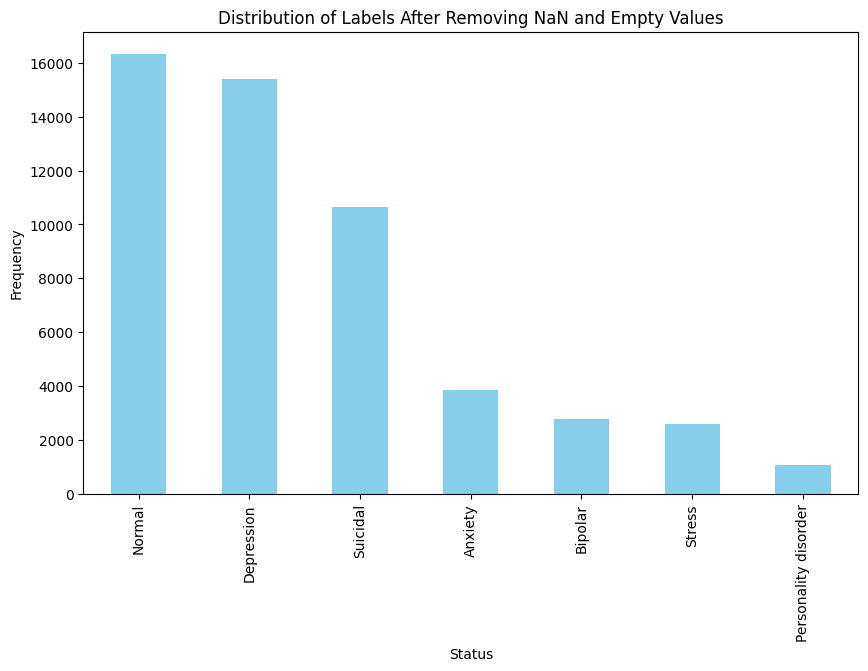

In [49]:
#Check distribution of data after NaNs and empty values removed

label_distribution = df_new['status'].value_counts()
print("Label Distribution After Cleaning:")
print(label_distribution)


# Plot label distribution
plt.figure(figsize=(10, 6))
label_distribution.plot(kind='bar', color='skyblue')
plt.xlabel('Status')
plt.ylabel('Frequency')
plt.title('Distribution of Labels After Removing NaN and Empty Values')
plt.show()

Distribution looks relatively similar to original distribution after removing NaNs and empty values. This alleviates the concern that one column had a disproportionately high number of missing values.

In [53]:
#Function to remove contractions and separate into two words

import re

# Remove extra spaces around apostrophes in contractions
df_new['cleaned_statement'] = df_new['cleaned_statement'].str.replace(r"\s+([’'])\s+", r"\1", regex=True)

# Define a function to expand contractions
def expand_contractions(text):
    contractions_dict = {
        r"\bdon(?:'|’)?t\b": "do not",
        r"\bcan(?:'|’)?t\b": "cannot",
        r"\bi(?:'|’)?m\b": "i am",
        r"\byou(?:'|’)?re\b": "you are",
        r"\bthey(?:'|’)?ve\b": "they have",
        r"\bit(?:'|’)?s\b": "it is",
        r"\bis(?:'|’)?nt\b": "is not",
        r"\bwon(?:'|’)?t\b": "will not",
        r"\bdid(?:'|’)?nt\b": "did not",
        r"\bcould(?:'|’)?nt\b": "could not",
        r"\bwould(?:'|’)?nt\b": "would not",
        r"\bshould(?:'|’)?nt\b": "should not",
        r"\bdoes(?:'|’)?nt\b": "does not",
        r"\bain(?:'|’)?t\b": "is not",
        r"\bi(?:'|’)?ve\b": "i have",
        r"\bwe(?:'|’)?re\b": "we are",
        r"\bthere(?:'|’)?s\b": "there is",
        r"\bit(?:'|’)?d\b": "it would",
        r"\bwho(?:'|’)?s\b": "who is",
        r"\bwhat(?:'|’)?s\b": "what is",
        r"\bthat(?:'|’)?s\b": "that is",
        r"\blet(?:'|’)?s\b": "let us",
        r"\by(?:'|’)?all\b": "you all",
        r"\bma(?:'|’)?am\b": "madam"
    }

    # Apply each contraction replacement
    for contraction, expanded in contractions_dict.items():
        text = re.sub(contraction, expanded, text)
    return text

# Apply the contraction expansion function multiple times to catch overlaps
for _ in range(2):  # Repeat if necessary
    df_new['cleaned_statement'] = df_new['cleaned_statement'].apply(expand_contractions)






In [54]:
#Sanity check to make sure none of the specified contractions remain

# List of contraction patterns to check for remaining occurrences
remaining_contractions_patterns = [
    r"\bdon(?:'|’)?t\b", r"\bcan(?:'|’)?t\b", r"\bi(?:'|’)?m\b", r"\byou(?:'|’)?re\b",
    r"\bthey(?:'|’)?ve\b", r"\bit(?:'|’)?s\b", r"\bis(?:'|’)?nt\b", r"\bwon(?:'|’)?t\b",
    r"\bdid(?:'|’)?nt\b", r"\bcould(?:'|’)?nt\b", r"\bwould(?:'|’)?nt\b", r"\bshould(?:'|’)?nt\b",
    r"\bdoes(?:'|’)?nt\b", r"\bain(?:'|’)?t\b", r"\bi(?:'|’)?ve\b", r"\bwe(?:'|’)?re\b",
    r"\bthere(?:'|’)?s\b", r"\bit(?:'|’)?d\b", r"\bwho(?:'|’)?s\b", r"\bwhat(?:'|’)?s\b",
    r"\bthat(?:'|’)?s\b", r"\blet(?:'|’)?s\b", r"\by(?:'|’)?all\b", r"\bma(?:'|’)?am\b"
]

# Check for each contraction and count occurrences
for pattern in remaining_contractions_patterns:
    count = df_new['cleaned_statement'].str.contains(pattern, regex=True).sum()
    print(f"Contraction pattern '{pattern}': {count} occurrences remaining")


Contraction pattern '\bdon(?:'|’)?t\b': 0 occurrences remaining
Contraction pattern '\bcan(?:'|’)?t\b': 0 occurrences remaining
Contraction pattern '\bi(?:'|’)?m\b': 0 occurrences remaining
Contraction pattern '\byou(?:'|’)?re\b': 0 occurrences remaining
Contraction pattern '\bthey(?:'|’)?ve\b': 0 occurrences remaining
Contraction pattern '\bit(?:'|’)?s\b': 0 occurrences remaining
Contraction pattern '\bis(?:'|’)?nt\b': 0 occurrences remaining
Contraction pattern '\bwon(?:'|’)?t\b': 0 occurrences remaining
Contraction pattern '\bdid(?:'|’)?nt\b': 0 occurrences remaining
Contraction pattern '\bcould(?:'|’)?nt\b': 0 occurrences remaining
Contraction pattern '\bwould(?:'|’)?nt\b': 0 occurrences remaining
Contraction pattern '\bshould(?:'|’)?nt\b': 0 occurrences remaining
Contraction pattern '\bdoes(?:'|’)?nt\b': 0 occurrences remaining
Contraction pattern '\bain(?:'|’)?t\b': 0 occurrences remaining
Contraction pattern '\bi(?:'|’)?ve\b': 0 occurrences remaining
Contraction pattern '\bwe(?:

In [55]:
#Sanity check to check for presence of expanded form

# Dictionary of expected expansions
expected_expansions = {
    "do not": "do not",
    "cannot": "cannot",
    "i am": "i am",
    "you are": "you are",
    "they have": "they have",
    "it is": "it is",
    "is not": "is not",
    "will not": "will not",
    "did not": "did not",
    "could not": "could not",
    "would not": "would not",
    "should not": "should not",
    "does not": "does not",
    "is not": "is not",
    "i have": "i have",
    "we are": "we are",
    "there is": "there is",
    "it would": "it would",
    "who is": "who is",
    "what is": "what is",
    "that is": "that is",
    "let us": "let us",
    "you all": "you all",
    "madam": "madam"
}

# Check for presence of expanded forms
for expanded in expected_expansions.values():
    has_expansion = df_new['cleaned_statement'].str.contains(expanded, case=False).any()
    print(f"Expanded form '{expanded}' found? {has_expansion}")


Expanded form 'do not' found? True
Expanded form 'cannot' found? True
Expanded form 'i am' found? True
Expanded form 'you are' found? True
Expanded form 'they have' found? True
Expanded form 'it is' found? True
Expanded form 'is not' found? True
Expanded form 'will not' found? True
Expanded form 'did not' found? True
Expanded form 'could not' found? True
Expanded form 'would not' found? True
Expanded form 'should not' found? True
Expanded form 'does not' found? True
Expanded form 'i have' found? True
Expanded form 'we are' found? True
Expanded form 'there is' found? True
Expanded form 'it would' found? True
Expanded form 'who is' found? True
Expanded form 'what is' found? True
Expanded form 'that is' found? True
Expanded form 'let us' found? True
Expanded form 'you all' found? True
Expanded form 'madam' found? True


In [56]:
#Check text lengths

import seaborn as sns
df_new['text_length'] = df_new['statement'].astype(str).apply(len)
df_new['text_length'].describe()

,text_length
count,52681.000000
mean,578.713863
std,846.269078
min,2.000000
25%,80.000000
50%,317.000000
75%,752.000000
max,32759.000000


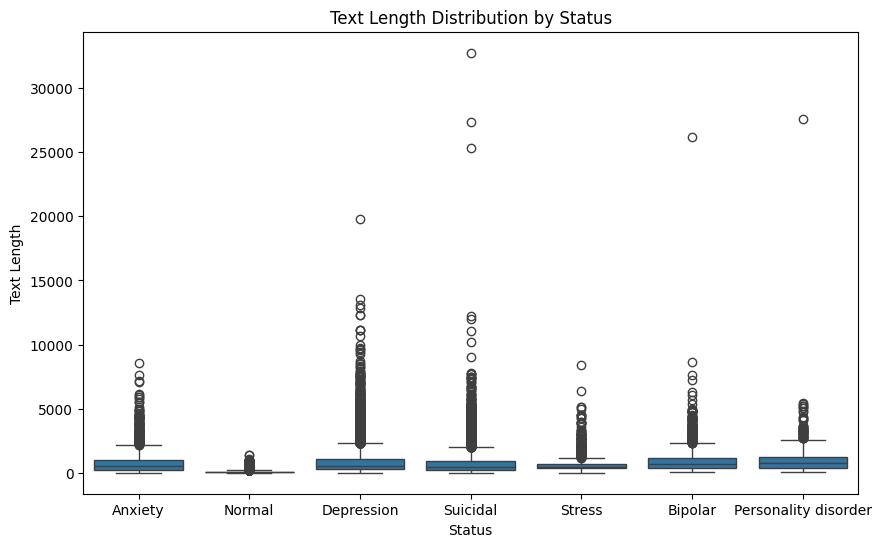

In [57]:
#Visual depiction of distribution of text lengths

plt.figure(figsize=(10, 6))
sns.boxplot(x='status', y='text_length', data=df_new)
plt.title('Text Length Distribution by Status')
plt.xlabel('Status')
plt.ylabel('Text Length')
plt.show()

As we can see, text entries labeled "normal" are much shorter than other entries. Also, it is interesting to see the outliers of each label. Shows that a lot of statements are short in nature, but we have a significant amount for each label in Quartile 4 that have a very high text length.

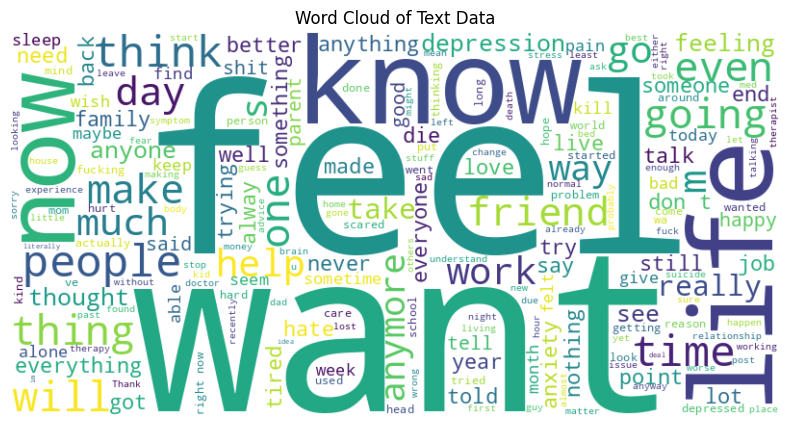

In [58]:
#Word Cloud to show commonly occuring words

from wordcloud import WordCloud, STOPWORDS

# Combine all text data
text_data = ' '.join(df_new['statement'].astype(str).tolist())

# Create and display the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate(text_data)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Text Data')
plt.show()